In [44]:
import numpy as np
import pandas as pd
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
import re
from math import ceil
import gseapy as gp

def enrichr_analysis(gene_list, gene_set='GO_Biological_Process_2023', organism='mouse', pval_threshold=0.05):
    """Perform Enrichr analysis and return filtered results."""
    try:
        enrichr_results = gp.enrichr(
            gene_list=gene_list,
            gene_sets=gene_set,
            organism=organism
        )
        enrichr_df = enrichr_results.results
    except Exception as e:
        print(f"Enrichr analysis failed: {e}")
        return None
   
    # Adjust p-values and filter significant terms
    enrichr_df = enrichr_df[enrichr_df['Adjusted P-value'] <= pval_threshold].copy()
    # Remove (GO:#####) string
    enrichr_df['Term'] = [i.split(' (')[0] for i in enrichr_df['Term']]

    return enrichr_df[['Term', 'Adjusted P-value', 'Genes']]


def generate_pathway_graph(df1, output_name=None):
    # Extract all genes
    All_gl = [i.split(";") for i in df1['Genes']]
    all_genes = [gene for sublist in All_gl for gene in sublist]

    # Create binary gene-pathway matrix
    pathway_gene_df = pd.DataFrame(np.zeros([df1.shape[0], len(all_genes)]), 
                                   index=df1.Term, 
                                   columns=all_genes)

    for i in range(df1.shape[0]):
        for gene in df1['Genes'].iloc[i].split(";"):
            pathway_gene_df.loc[df1.Term.iloc[i], gene] = 1

    # Correlation matrix and adjacency network
    A = np.corrcoef(pathway_gene_df)
    np.fill_diagonal(A, 0)
    Pathnet = pd.DataFrame(A, columns=pathway_gene_df.index, index=pathway_gene_df.index)
    Pathnet[Pathnet < 0.3] = 0

    # Create network graph
    PathGraph = nx.from_pandas_adjacency(Pathnet)
    partition = nx.community.louvain_communities(PathGraph, resolution=1, seed=42)
    nx.set_node_attributes(PathGraph, partition, 'group')
    nx.set_node_attributes(PathGraph, dict(zip(pathway_gene_df.index, pathway_gene_df.sum(axis=1))), 'ngenes')

    # Filter clusters
    filtered_partition = [community for community in partition if len(community) > 1]

    # Color map for clusters
    color_map = []
    for node in PathGraph:
        for i, community in enumerate(filtered_partition):
            if node in community:
                color_map.append(i)
                break
        else:
            color_map.append(-1)

    # Filter nodes with more than 2 links
    nodes_to_plot = [node for node, degree in PathGraph.degree() if degree >= 1]
    subgraph = PathGraph.subgraph(nodes_to_plot)

    # Color map for the subgraph
    subgraph_color_map = [color_map[list(PathGraph.nodes()).index(node)] for node in subgraph.nodes()]

    # Layout for graph visualization
    pos = nx.fruchterman_reingold_layout(subgraph, seed=42, k=0.3)

    # Function to wrap text labels
    def wrap_label(label, width=20):
        words = label.split()
        wrapped_label = ''
        line = ''
        for word in words:
            if len(line) + len(word) + 1 <= width:
                line += (word + ' ')
            else:
                wrapped_label += (line + '\n')
                line = word + ' '
        wrapped_label += line
        return wrapped_label.strip()

    labels = {node: wrap_label(node) for node in subgraph.nodes()}

    # Draw the graph
    plt.figure(figsize=(6, 6))
    node_sizes = [PathGraph.nodes[node]['ngenes'] * 10 for node in subgraph.nodes()]
    nx.draw(subgraph, pos=pos, node_size=node_sizes, font_size=10,
             node_color=subgraph_color_map, edge_color='gray', font_color='black',
             font_weight='bold', width=0.5, alpha=1, cmap=plt.cm.tab10)

    # Find largest nodes per cluster for labeling
    largest_nodes = {}
    for node in subgraph.nodes():
        cluster = subgraph_color_map[list(subgraph.nodes()).index(node)]
        if cluster not in largest_nodes or PathGraph.nodes[node]['ngenes'] > PathGraph.nodes[largest_nodes[cluster]]['ngenes']:
            largest_nodes[cluster] = node

    # Draw largest node labels
    for node, coords in pos.items():
        if node in largest_nodes.values():
            x, y = coords
            plt.text(x, y, labels[node], fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))

    # Add plot title
    num_pathways = df1.shape[0]  # Get the number of pathways from df1
    plt.title(f"Pathways clustered by gene overlap (Pval_adj<=0.05) \n Number of pathways: {num_pathways}")

    # Save the plot as PNG if output_name is provided
    if output_name:
        plt.savefig(output_name, format='png', bbox_inches='tight')
    
    # Show the plot
    plt.show()


def remove_common_terms(df1, df2):
    """ Removes common terms from df1 that are present in df2.
        Returns:
        pd.DataFrame: df1 with common terms removed.
    """
    common_terms = set(df1['Term']).intersection(set(df2['Term']))
    df1_filtered = df1[~df1['Term'].isin(common_terms)].copy()
    return df1_filtered

In [45]:
fname = "qubo_features.txt"
gl1 = pd.read_csv(fname, sep='\t', header=None)[0].tolist()
fname = "lasso_features.txt"
gl2 = pd.read_csv(fname, sep='\t', header=None)[0].tolist()

# Compute enrichr analysis
df1 = enrichr_analysis(gl1)
df2 = enrichr_analysis(gl2)

df1_filt = remove_common_terms(df1, df2)

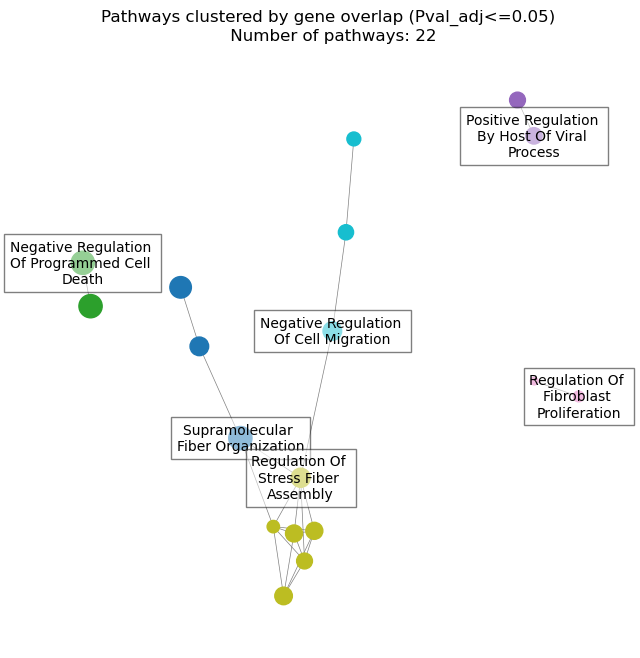

In [46]:
generate_pathway_graph(df1_filt,output_name='qubo_vs_lasso_unique_pathways_clust.png')

In [32]:
fname = "qubo_features.txt"
gl1 = pd.read_csv(fname, sep='\t', header=None)[0].tolist()
fname = "fittree_features.txt"
gl2 = pd.read_csv(fname, sep='\t', header=None)[0].tolist()

# Compute enrichr analysis
df1 = enrichr_analysis(gl1)
df2 = enrichr_analysis(gl2)

df1_filt = remove_common_terms(df1, df2)

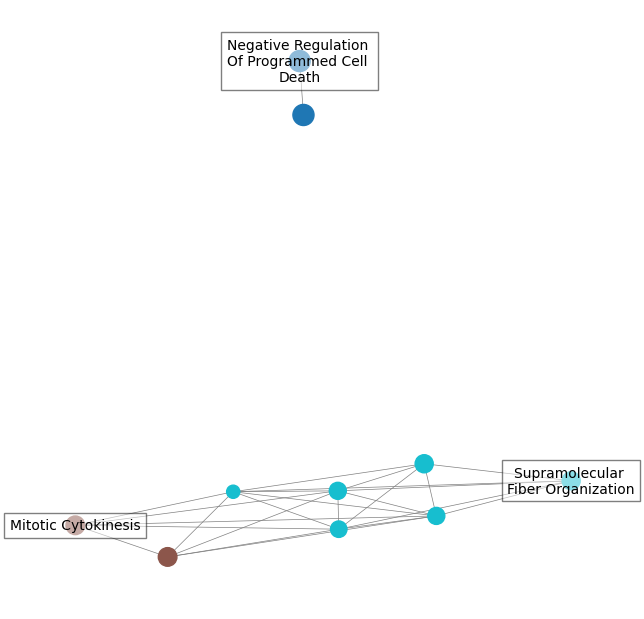

In [33]:
generate_pathway_graph(df1_filt,output_name='qubo_vs_fittree_unique_pathways_clust.png')

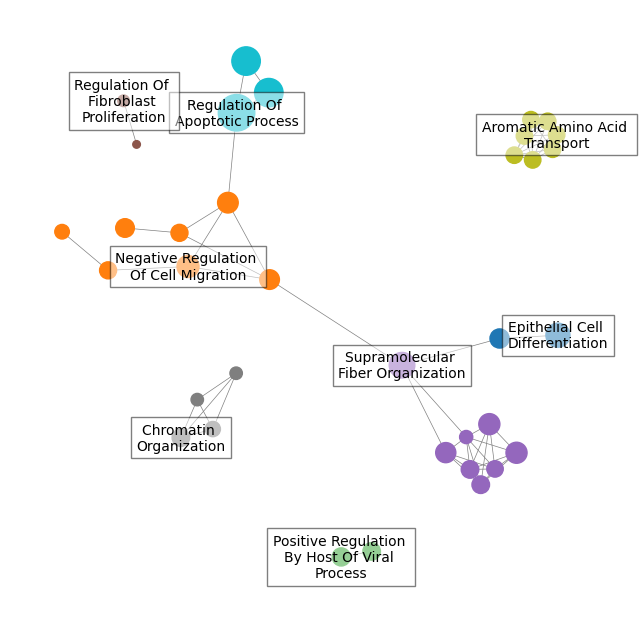

In [34]:
generate_pathway_graph(df1,output_name='qubo_all_pathways_clust.png')